In [2]:
import phenograph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os

from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

plt.rcdefaults()
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

In [3]:
adata_10clu = sc.read_h5ad('E:/Papers/MuConST/simulation_low_drop_10_clusters.h5ad')
adata_10clu

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'gt', 'mclust', 'muse', 'transcript', 'morphology', 'FeatureCat', 'cca', 'ae', 'Our'
    obsm: 'augment_gene_data', 'feat', 'feat_fake', 'final_emb', 'image_feature', 'label_CSL', 'spatial'

In [4]:
label_true = adata_10clu.obs['gt']
label_true

0      6
1      2
2      4
3      7
4      8
      ..
995    8
996    2
997    9
998    3
999    0
Name: gt, Length: 1000, dtype: int64

In [5]:
from mucstpy import construction_interaction

construction_interaction(adata_10clu, n_neighbor=6)
adj = adata_10clu.obsm['adj']

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [6]:
from mucstpy import add_contrastive_label, get_feature
from mucstpy.MuCST import train_model
import torch

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

add_contrastive_label(adata_10clu)
get_feature(adata_10clu)
gene_dims=[adata_10clu.shape[1], 64]
img_dims=[adata_10clu.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32]


adata_10clu.obsm['aug_image_feature1'] = adata_10clu.obsm['image_feature']
adata_10clu.obsm['aug_image_feature2'] = adata_10clu.obsm['image_feature']
train_model(adata_10clu, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=1, device=device, adj_key='adj')

Begin to train MuCST...


# Epoch 1501, loss: 15.566, g2i_loss: 8.450, g2g_loss: 0.406, i2i_loss: 6.977, gene_recon: 0.067, image_recon: 0.032:  97%|█████████▋| 1501/1550 [00:08<00:00, 124.65it/s]

# Epoch 1500, loss: 15.798, g2g_loss: 0.406, gene_recon: 0.066, image_recon: 0.032
Init finished, start contrastive learning part


# Epoch 1549, loss: 11.868, g2i_loss: 6.505, g2g_loss: 0.465, i2i_loss: 5.196, gene_recon: 0.075, image_recon: 0.045: 100%|██████████| 1550/1550 [00:14<00:00, 106.11it/s]

Optimization of MuCST finished


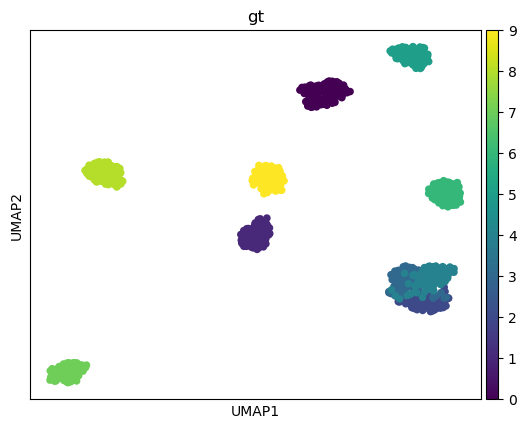

In [7]:
sc.pp.neighbors(adata_10clu, use_rep='fusion_pca')
sc.tl.umap(adata_10clu)
sc.pl.umap(adata_10clu, color=['gt'])

In [12]:
from sklearn.metrics import adjusted_rand_score

sc.tl.leiden(adata_10clu, key_added='mucst_leiden', resolution=1.3)
ARI = adjusted_rand_score(adata_10clu.obs['gt'], adata_10clu.obs['mucst_leiden'])

In [13]:
adata_10clu.obs['mucst_leiden']

0      4
1      3
2      9
3      7
4      1
      ..
995    1
996    3
997    2
998    5
999    0
Name: mucst_leiden, Length: 1000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

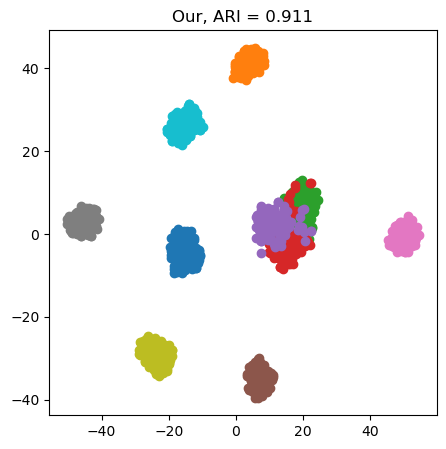

In [14]:
from sklearn.manifold import TSNE

plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)

X_embedded = TSNE(n_components=2).fit_transform(adata_10clu.obsm['fusion_pca'])
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Our, ARI = %01.3f' % ARI)

### Display the result on simulated data

In [15]:
pca_emb = PCA(n_components=32, random_state=42)

latent_trans_pcs = pca_emb.fit_transform(adata_10clu.obsm['latent_gene'])
latent_img_pcs = pca_emb.fit_transform(adata_10clu.obsm['latent_img'])
fusion_pca_emb = latent_trans_pcs + latent_img_pcs
adata_10clu.obsm['latent_emb_fusion'] = fusion_pca_emb

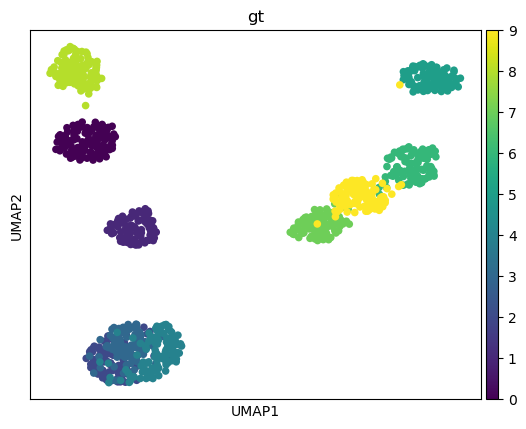

In [16]:
sc.pp.neighbors(adata_10clu, use_rep='latent_emb_fusion')
sc.tl.umap(adata_10clu)
sc.pl.umap(adata_10clu, color=['gt'])

In [18]:
sc.tl.leiden(adata_10clu, key_added='mucst_emb_leiden', resolution=1.3)
adata_10clu.obs['mucst_emb_leiden']

0      4
1      1
2      8
3      5
4      2
      ..
995    2
996    9
997    3
998    8
999    0
Name: mucst_emb_leiden, Length: 1000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [19]:
ARI = adjusted_rand_score(adata_10clu.obs['gt'], adata_10clu.obs['mucst_emb_leiden'])
print(ARI)

0.8477377207136029


#### We demonstrate that tSNE plot based on latent embeddings perform worse than reconstructed data

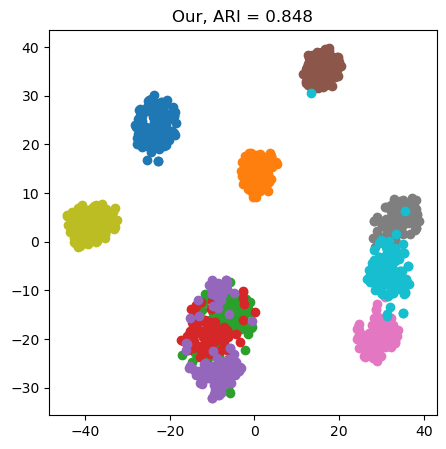

In [21]:
from sklearn.manifold import TSNE

plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)

X_embedded = TSNE(n_components=2).fit_transform(adata_10clu.obsm['latent_emb_fusion'])
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Our, ARI = %01.3f' % ARI)